# **Anime Sketch Colorization Pair**






**Problem statement:**

For a given sketch generate a Color Image

**Data Overview**

Taken data from Danbooru Sketch Pair 128x on kaggle https://www.kaggle.com/wuhecong/danbooru-sketch-pair-128x

We are given two Folders:-

- Skecth - Having  sketch images

- Color - Having corresponding Colored images.

We will pick some images from these folders to train the model and then test it on some pairs not seen by the model.


**Real-world/Business objectives and constraints.**

*   No low-latency requirement.
*   Images generated should have colors same as original image and shouldn't be blurred.


**Performance metric for supervised learning:**


*   Mean Absolute Error/  L1 Loss (L1 dist per pixel)

 




**Solution :-**

We will try to generate Color Images using below models -
 - Unet model to minimize Mean Absolute error at Pixel Level.
 - We will also pass color hints thru some pixels from target image.

**1. Download the Images.**

In [1]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.106 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/198718/800362/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1584122188&Signature=RGLmewJ47Mt%2B%2FWB%2BLWFPREd%2Fy1OfIa%2BxS3PyDBQe7qPtL71FlsnGfSC6gIJrHMoYRdCh%2F78eubQNBBheY7VcyeBCME3WsKv%2F%2BElXoB85DOUhQxOT02qtaplFvP2zYSsnRKCMW5FzcOdh%2Bgo7KnlO%2BgjHPCq53HaVK1qqATuDrEU5FRHAer2AuO%2Ba1In2J3yvRF7nztUwkRzeSAccQcm4rUUaVDGB%2Bj7vcvPUitBrMG9iZK4zlqWZm63K0%2F3RY3hH9jbggGCcX07bd7ReLRLrfuRzTCktlEHnO%2BYsGIJBO9Y%2Fc6VWPD5oSm09rgYZsLIumlMXeMKC8CnhV4gUwNeeSw%3D%3D&response-content-disposition=attachment%3B+filename%3Ddanbooru-sketch-pair-128x.zip" -O "danbooru-sketch-pair-128x.zip" -c

--2020-03-11 14:53:40--  https://storage.googleapis.com/kaggle-data-sets/198718/800362/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1584122188&Signature=RGLmewJ47Mt%2B%2FWB%2BLWFPREd%2Fy1OfIa%2BxS3PyDBQe7qPtL71FlsnGfSC6gIJrHMoYRdCh%2F78eubQNBBheY7VcyeBCME3WsKv%2F%2BElXoB85DOUhQxOT02qtaplFvP2zYSsnRKCMW5FzcOdh%2Bgo7KnlO%2BgjHPCq53HaVK1qqATuDrEU5FRHAer2AuO%2Ba1In2J3yvRF7nztUwkRzeSAccQcm4rUUaVDGB%2Bj7vcvPUitBrMG9iZK4zlqWZm63K0%2F3RY3hH9jbggGCcX07bd7ReLRLrfuRzTCktlEHnO%2BYsGIJBO9Y%2Fc6VWPD5oSm09rgYZsLIumlMXeMKC8CnhV4gUwNeeSw%3D%3D&response-content-disposition=attachment%3B+filename%3Ddanbooru-sketch-pair-128x.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10424880981 (9.7G) [application/zip]
Saving to: ‘danbooru-sketch-pair-128x.zip’

danbooru

In [0]:
#Extract Images from zip folder.
#Ref- https://stackoverflow.com/questions/3451111/unzipping-files-in-python
from zipfile import ZipFile
with ZipFile('danbooru-sketch-pair-128x.zip', 'r') as zf:
    zf.extractall('sketch-pair/')

**2. Import Required Libraries.**

In [3]:
#Import all the required libraries. 
import warnings #Suppress warning. 
warnings.filterwarnings("ignore")

from keras.layers import Activation, Dense, Dropout, Flatten, Input, Add, Conv2D, Conv2DTranspose, LeakyReLU #Keras Layers.
from keras.layers.normalization import BatchNormalization #Batch Normalization for keras layer.
from keras.models import Model #Keras Model
from keras.optimizers import Adam #Adam Optimizer.
from keras import losses #Keras Loss function.
import numpy as np #Numpy array handling.
import os #System variables.
import random #Library to generate random numbers
import cv2 #Image processing.
from google.colab.patches import cv2_imshow #library to show images in Colab
import matplotlib.pyplot as pyplot #Plotting graphs
from datetime import datetime #Using this library for timer.
import tensorflow as tf
from keras.callbacks import TensorBoard
from keras.regularizers import l2


Using TensorFlow backend.


**3. Load Data**

In [0]:
#Load Name of files.

img_name = [] #Array to store name of the image.

for i in  range(26): #Processing first 15 folders.
  folder=i.__str__().zfill(4) #Printing Folder number in 4 byte format.
  loc = 'sketch-pair/danbooru-sketch-pair-128x/color/sketch/' + folder + '/' #location of sketch images.
  for filename in os.listdir(loc):    #Process each image from the current folder.
    img_name.append(folder+'/'+filename)  #Store folder + filename.

In [5]:
print('Total number of images:',len(img_name))

Total number of images: 51437


In [0]:
#Generate List of Train, test and validation images.
img_tr  = img_name[0:10000]
img_val = img_name[10000:11500]
img_tst = img_name[11500:13000]

In [7]:
#Sample name of an image
img_tst[0]

'0005/1043005.png'

In [8]:
#Length of train, test and validation data.
print('Number of images in train data:',len(img_tr))
print('Number of images in validation data:',len(img_val))
print('Number of images in test data:',len(img_tst))

Number of images in train data: 10000
Number of images in validation data: 1500
Number of images in test data: 1500


In [0]:
#Initialize batch pointers.
train_batch_pointer = 0
val_batch_pointer = 0

**4. GAN Model to generate Color Images**

In [0]:
#Defining a Random Gaussian variable to initialize weight for Conv layers.
from keras.initializers import RandomNormal
init = RandomNormal(stddev=0.02)

In [0]:
#Function to generate U-net Model.
#Most of the papers suggested GAN model to generate images. But before jumping directly 
#to a complex GAN Model, I tried using simply Generator module to generate images 
#improving Pixelwise crossentropy loss.
#For the Generator Architecture referred - https://github.com/kvfrans/deepcolor/blob/master/main.py.
#The Code above was in tensor-flow. So, changed that to a Keras model.
#Also, left the learning paramters as default value, so that model learns faster.

def color_image():

    #Encoder Unit
    #Input Layer (128, 128, 3)
    encoder_input = Input(shape=(128, 128, 3,)) 
    #Layer-1 Output image of shape - 64 * 64 * 64
    encoder_output_1 = Conv2D(64, (5,5), padding='same',  strides=2, kernel_initializer=init)(encoder_input) 
    #Leaky ReLUs allow a small, non-zero gradient when the unit is not active. 
    encoder_output_2 = LeakyReLU(alpha=0.2)(encoder_output_1)  
    #Layer-2 Output image of shape - 32 * 32 * 128
    encoder_output_2 = Conv2D(128, (5,5),  padding='same', strides=2, kernel_initializer=init)(encoder_output_2)
    #Batch Normalization.
    encoder_output_2 = BatchNormalization(momentum=0.9)(encoder_output_2)
    #Layer-3 Output image of shape - 16 * 16 * 256
    encoder_output_3 = LeakyReLU(alpha=0.2)(encoder_output_2)
    encoder_output_3 = Conv2D(256, (5,5),  padding='same',  strides=2, kernel_initializer=init)(encoder_output_3)
    encoder_output_3 = BatchNormalization(momentum=0.9)(encoder_output_3)
    #Layer-4 Output image of shape - 8 * 8 * 512
    encoder_output_4 = LeakyReLU(alpha=0.2)(encoder_output_3)
    encoder_output_4 = Conv2D(512, (5,5),  padding='same',  strides=2, kernel_initializer=init)(encoder_output_4)
    encoder_output_4 = BatchNormalization(momentum=0.9)(encoder_output_4)
    #Layer-5 Output image of shape - 4 * 4 * 512
    encoder_output_5 = LeakyReLU(alpha=0.2)(encoder_output_4)
    encoder_output_5 = Conv2D(512, (5,5),  padding='same',  strides=2, kernel_initializer=init)(encoder_output_5)
    encoder_output_5 = BatchNormalization(momentum=0.9)(encoder_output_5)


    
    #Decoder Unit
    #Conv2DTranspose - The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite 
    #direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to 
    #something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution.
    #Ref- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose
    #Layer-6 Output image of shape - 8 * 8 * 512
    encoder_output_6 = Conv2DTranspose(512, (5,5), padding='same', activation='relu', strides=2, kernel_initializer=init)(encoder_output_5)
    encoder_output_6  = BatchNormalization(momentum=0.9)(encoder_output_6)
    #Concatenating output from previous layer with output from layer-4. Both are of same dimension.
    encoder_output_6 = Add()([encoder_output_6, encoder_output_4])
    #Layer-7 Output image of shape - 16 * 16 * 256
    encoder_output_7 = Conv2DTranspose(256, (5,5), padding='same', activation='relu', strides=2, kernel_initializer=init)(encoder_output_6)
    encoder_output_7  = BatchNormalization(momentum=0.9)(encoder_output_7)
    #Concatenating output from previous layer with output from layer-3. Both are of same dimension.
    encoder_output_7 = Add()([encoder_output_7, encoder_output_3])
    #Layer-8 Output image of shape - 32 * 32 * 128
    encoder_output_8 = Conv2DTranspose(128, (5,5), padding='same', activation='relu', strides=2, kernel_initializer=init)(encoder_output_7)
    encoder_output_8  = BatchNormalization(momentum=0.9)(encoder_output_8)
    #Concatenating output from previous layer with output from layer-2. Both are of same dimension.
    encoder_output_8 = Add()([encoder_output_8, encoder_output_2]) 
    #Layer-9 Output image of shape - 64 * 64 * 64
    encoder_output_9 = Conv2DTranspose(64, (5,5), padding='same', activation='relu', strides=2, kernel_initializer=init)(encoder_output_8)
    encoder_output_9  = BatchNormalization(momentum=0.9)(encoder_output_9)
    #Concatenating output from previous layer with output from layer-1. Both are of same dimension
    encoder_output_9 = Add()([encoder_output_9, encoder_output_1]) 
    #Layer-10 (Output Layer) Output image of shape - 128 * 128 * 3
    encoder_output = Conv2DTranspose(3, (5,5), padding='same', activation='tanh', strides=2, kernel_initializer=init)(encoder_output_9)
    
    #Defining Model with input and Outputs.
    model = Model(encoder_input, encoder_output)

    #Adam Optimizer.
    opt = Adam(lr=0.0002, beta_1=0.5)  
    
    #Compile Model with Adam Optimizer and Mean Absolute Error.
    model.compile(optimizer=opt, loss=['mae'])
    #Return Model.
    return model

In [12]:
#Calling the U-net model eefined above and print its summary.
model = color_image()
model.summary()













Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 128)  204928      leaky_re_lu_1[0][0]              
________________________________________________________________________________

In [0]:
#Plot model performance.
def plot_history(tr_loss, val_loss):
# plot Loss
 pyplot.plot(tr_loss, label='Training Loss')
 pyplot.plot(val_loss, label='Validation Loss')
 pyplot.gca().set_title("Model Loss")
 pyplot.legend()
 pyplot.show()

In [0]:
#Function to generate batch of images for model training.

def generate_train_batch(arr, n_samples):
#Arguments.
#arr - array with image names.
#n_samples - Number of samples to be generated.

  
  #Pointer to track number of images processed in last batch
  global train_batch_pointer

  #Arrays to store batch sample of sketches and color images.
  X_sketches = []
  X_color = []

  #Loop to generate sketeches and color image arrays.
  for i in range(n_samples):
    
    #Location for sketch images.
    loc = 'sketch-pair/danbooru-sketch-pair-128x/color/sketch/'
    #Read the image.
    img = cv2.imread(loc+arr[(i + train_batch_pointer) % len(arr)],1)
    #Converting to RGB format for processing.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Append image array in the list.
    X_sketches.append(img)

    #Location for color images.
    loc = 'sketch-pair/danbooru-sketch-pair-128x/color/src/' 
    #Read the image.
    img = cv2.imread(loc+arr[(i + train_batch_pointer) % len(arr)],1)
    #Converting to RGB format for processing.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Append image array in the list.
    X_color.append(img)

  #Update train batch pointer.
  train_batch_pointer +=  n_samples
  
  #Converting list to arrays.
  X_sketches = np.array(X_sketches)
  X_color = np.array(X_color)

  #Set of pixels to pass color hints from target image.
  pix1=[64,32,96,32,96,32,64,64,96,16,32,16,16,64,16,96,112,112,96,80]
  pix2=[64,32,96,96,32,64,32,96,64,16,16,32,64,16,96,16,112,96,112,80]
  
  #Loop below to generate color hints for all images in sample.
  for i in range(n_samples):
    #Passing hints for 20 patches of 7*7
    for l in range(20):
      #Populating color hints for a patch of 7*7
      for j in range(7):
        for k in range(7):
         X_sketches[i,pix1[l]+j,pix2[l]+k] = X_color[i,pix1[l]+j,pix2[l]+k]

  #Normalize data to -1 to +1 format.
  X_sketches = (X_sketches - 127.5) / 127.5
  X_color = (X_color - 127.5) / 127.5


  #return batch of sketches and color images.
  return X_sketches, X_color

In [0]:
#Function to generate batch of images for model training.

def generate_val_batch(arr, n_samples):
#Arguments.
#arr - array with image names.
#n_samples - Number of samples to be generated.

  
  #Pointer to track number of images processed in last batch
  global val_batch_pointer

  #Arrays to store batch sample of sketches and color images.
  X_sketches = []
  X_color = []

  #Loop to generate sketeches and color image arrays.
  for i in range(n_samples):
    #Location for sketch images.
    loc = 'sketch-pair/danbooru-sketch-pair-128x/color/sketch/'
    #Read the image.
    img = cv2.imread(loc+arr[(i + val_batch_pointer) % len(arr)],1)
    #Converting to RGB format for processing.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Append image array in the list.
    X_sketches.append(img)

    #Location for color images.
    loc = 'sketch-pair/danbooru-sketch-pair-128x/color/src/' 
    #Read the image.
    img = cv2.imread(loc+arr[(i + val_batch_pointer) % len(arr)],1)
    #Converting to RGB format for processing.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Append image array in the list.
    X_color.append(img)

  #Update Validation batch pointer.
  val_batch_pointer +=  n_samples
  
  #Converting list to arrays.
  X_sketches = np.array(X_sketches)
  X_color = np.array(X_color)

  #Set of pixels to pass color hints from target image.
  pix1=[64,32,96,32,96,32,64,64,96,16,32,16,16,64,16,96,112,112,96,80]
  pix2=[64,32,96,96,32,64,32,96,64,16,16,32,64,16,96,16,112,96,112,80]
  
  #Loop below to generate color hints for all images in sample.
  for i in range(n_samples):
    #Passing hints for 20 patches of 7*7
    for l in range(20):
      #Populating color hints for a patch of 7*7
      for j in range(7):
        for k in range(7):
         X_sketches[i,pix1[l]+j,pix2[l]+k] = X_color[i,pix1[l]+j,pix2[l]+k]


  #Normalize data to -1 to +1 format.
  X_sketches = (X_sketches - 127.5) / 127.5
  X_color = (X_color - 127.5) / 127.5


  #return batch of sketches and color images.
  return X_sketches, X_color

sketch


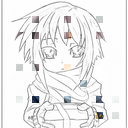

color


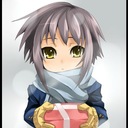

sketch


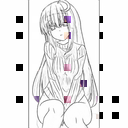

color


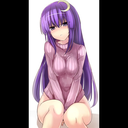

sketch


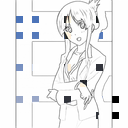

color


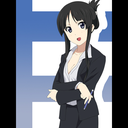

sketch


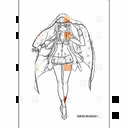

color


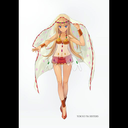

sketch


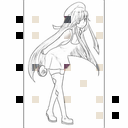

color


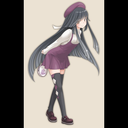

sketch


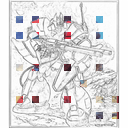

color


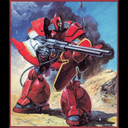

sketch


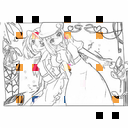

color


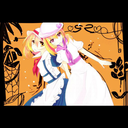

sketch


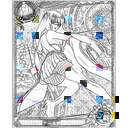

color


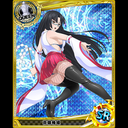

sketch


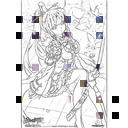

color


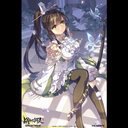

sketch


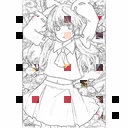

color


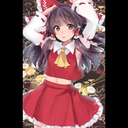

In [16]:
#Print some sample of images.

img_arr = [] #Array to store sketches.
col_arr = [] #Array to store color images.

n_samples = 10 #Number of sample want to be printed.

#Batch pointers
train_batch_pointer = 0
val_batch_pointer = 0

#Generate batch of skecth and corresponding color images.
img_arr, col_arr = generate_train_batch(img_tr, n_samples)

#Print generated images.
for i in range(10):
  print('sketch')
  #Convertng the generated image back to 0-255 value format.
  img = ((img_arr[i]+ 1)/2.0)*255.0
  #Converting back to BGR format required by cv2 library.
  img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
  #Show image
  cv2_imshow(img)

  print('color')
  #Convertng the generated image back to 0-255 value format.
  img = ((col_arr[i]+ 1)/2.0)*255.0
  #Converting back to BGR format required by cv2 library.
  img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)  
  #Show image
  cv2_imshow(img)


In [0]:
#Show generated images.

n_samples = 2 #Number of sample want to be printed.

#Resetting pointers to zero.
train_batch_pointer = 0
val_batch_pointer = 0

#Generate batch of skecth and corresponding color images.
X_tr, Y_tr = generate_train_batch(img_tr, n_samples)

#Generate batch of skecth and corresponding color images.
X_val, Y_val = generate_val_batch(img_val, n_samples)

#Resetting pointers to zero.
train_batch_pointer = 0
val_batch_pointer = 0

#Function to print generated images from train model using train and validation data.
def summarize_performance(model):

  #Generate image on samples from train data.
  gen_arr = model.predict(X_tr)

  #Print image on 2 samples from train data.
  for i in range(2):
    print('Train data : sketch image')
    #Convertng the generated image back to 0-255 value format.
    img = ((X_tr[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)

    print('Train data : color image')
    #Convertng the generated image back to 0-255 value format.
    img = ((Y_tr[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)

    print('Train data : Generated image')
    #Convertng the generated image back to 0-255 value format.
    img = ((gen_arr[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)
  
  #Generate image on samples from validation data.
  gen_arr = model.predict(X_val)

  #Print image on 2 samples from validation data.
  for i in range(2):
    print('Validation data : sketch image')
    #Convertng the generated image back to 0-255 value format.
    img = ((X_val[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)

    print('Validation data : color image')
    #Convertng the generated image back to 0-255 value format.
    img = ((Y_val[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)

    print('Validation data : Generated image')
    #Convertng the generated image back to 0-255 value format.
    img = ((gen_arr[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)

In [0]:
#Resetting pointers.
train_batch_pointer = 0
val_batch_pointer = 0



Iteration number: 0
Elapsed Time: 0:05:51.296827
Training Loss: [0.24003536]
Validation Loss: [0.2584633]
Train data : sketch image


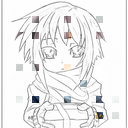

Train data : color image


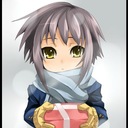

Train data : Generated image


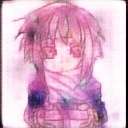

Train data : sketch image


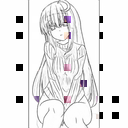

Train data : color image


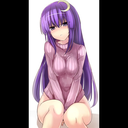

Train data : Generated image


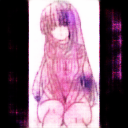

Validation data : sketch image


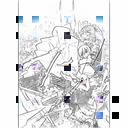

Validation data : color image


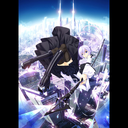

Validation data : Generated image


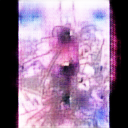

Validation data : sketch image


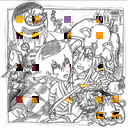

Validation data : color image


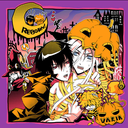

Validation data : Generated image


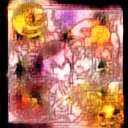

Iteration number: 1
Elapsed Time: 0:11:16.434516
Training Loss: [0.24003536, 0.19203436]
Validation Loss: [0.2584633, 0.2137927]
Train data : sketch image


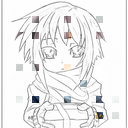

Train data : color image


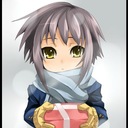

Train data : Generated image


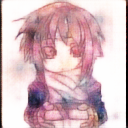

Train data : sketch image


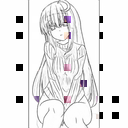

Train data : color image


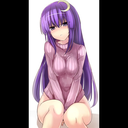

Train data : Generated image


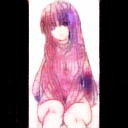

Validation data : sketch image


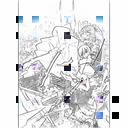

Validation data : color image


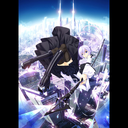

Validation data : Generated image


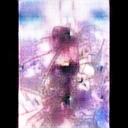

Validation data : sketch image


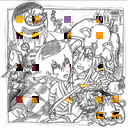

Validation data : color image


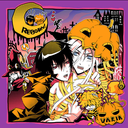

Validation data : Generated image


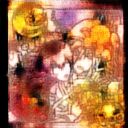

Iteration number: 20
Elapsed Time: 1:54:00.335186
Training Loss: [0.24003536, 0.19203436, 0.17810456, 0.16813812, 0.16012341, 0.15298101, 0.14695488, 0.141184, 0.13609621, 0.13156357, 0.1273665, 0.124409445, 0.121176064, 0.118250735, 0.115897134, 0.113256395, 0.11176272, 0.1095536, 0.10755104, 0.10636716, 0.1046526]
Validation Loss: [0.2584633, 0.2137927, 0.2031266, 0.19571297, 0.19264522, 0.18652034, 0.18517393, 0.18271735, 0.18089807, 0.17911789, 0.17908257, 0.17707722, 0.17686681, 0.1754061, 0.17479575, 0.17387678, 0.17403868, 0.17341526, 0.17275771, 0.17278507, 0.17230538]


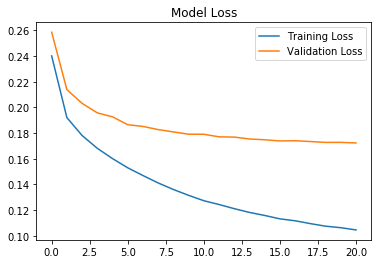

Saved model to disk
Train data : sketch image


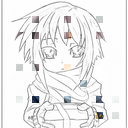

Train data : color image


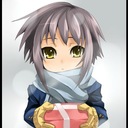

Train data : Generated image


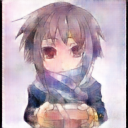

Train data : sketch image


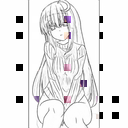

Train data : color image


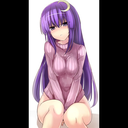

Train data : Generated image


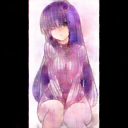

Validation data : sketch image


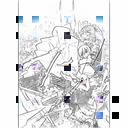

Validation data : color image


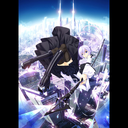

Validation data : Generated image


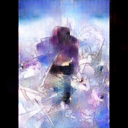

Validation data : sketch image


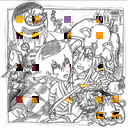

Validation data : color image


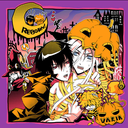

Validation data : Generated image


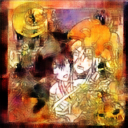

Iteration number: 40
Elapsed Time: 3:42:03.433160
Training Loss: [0.24003536, 0.19203436, 0.17810456, 0.16813812, 0.16012341, 0.15298101, 0.14695488, 0.141184, 0.13609621, 0.13156357, 0.1273665, 0.124409445, 0.121176064, 0.118250735, 0.115897134, 0.113256395, 0.11176272, 0.1095536, 0.10755104, 0.10636716, 0.1046526, 0.10328875, 0.102036916, 0.10086191, 0.09958117, 0.09852598, 0.097624734, 0.09641768, 0.095572405, 0.09479816, 0.09389701, 0.09307278, 0.092126735, 0.091483675, 0.09080186, 0.09018842, 0.08961847, 0.088857755, 0.088244, 0.08762115, 0.08742854]
Validation Loss: [0.2584633, 0.2137927, 0.2031266, 0.19571297, 0.19264522, 0.18652034, 0.18517393, 0.18271735, 0.18089807, 0.17911789, 0.17908257, 0.17707722, 0.17686681, 0.1754061, 0.17479575, 0.17387678, 0.17403868, 0.17341526, 0.17275771, 0.17278507, 0.17230538, 0.17227478, 0.17162286, 0.17234126, 0.17076209, 0.17126362, 0.17138407, 0.17053732, 0.17069808, 0.17068635, 0.17038548, 0.17028883, 0.16998103, 0.1698718, 0.17041673, 0.169

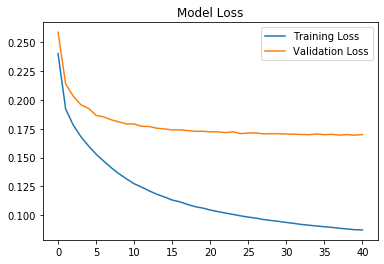

Saved model to disk
Train data : sketch image


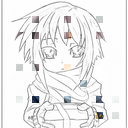

Train data : color image


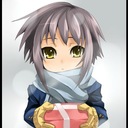

Train data : Generated image


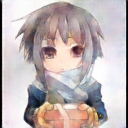

Train data : sketch image


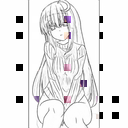

Train data : color image


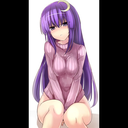

Train data : Generated image


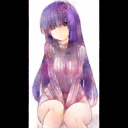

Validation data : sketch image


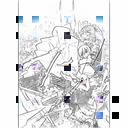

Validation data : color image


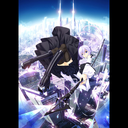

Validation data : Generated image


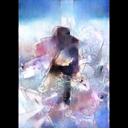

Validation data : sketch image


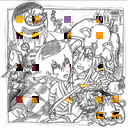

Validation data : color image


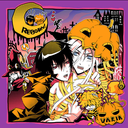

Validation data : Generated image


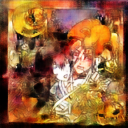

Iteration number: 60
Elapsed Time: 5:30:09.199353
Training Loss: [0.24003536, 0.19203436, 0.17810456, 0.16813812, 0.16012341, 0.15298101, 0.14695488, 0.141184, 0.13609621, 0.13156357, 0.1273665, 0.124409445, 0.121176064, 0.118250735, 0.115897134, 0.113256395, 0.11176272, 0.1095536, 0.10755104, 0.10636716, 0.1046526, 0.10328875, 0.102036916, 0.10086191, 0.09958117, 0.09852598, 0.097624734, 0.09641768, 0.095572405, 0.09479816, 0.09389701, 0.09307278, 0.092126735, 0.091483675, 0.09080186, 0.09018842, 0.08961847, 0.088857755, 0.088244, 0.08762115, 0.08742854, 0.08658026, 0.086185664, 0.08560257, 0.08496575, 0.08470075, 0.084103286, 0.08357076, 0.08319856, 0.082952015, 0.08238812, 0.081923984, 0.081633605, 0.08124385, 0.08096059, 0.08071973, 0.080127686, 0.07966286, 0.07955145, 0.07914931, 0.07882937]
Validation Loss: [0.2584633, 0.2137927, 0.2031266, 0.19571297, 0.19264522, 0.18652034, 0.18517393, 0.18271735, 0.18089807, 0.17911789, 0.17908257, 0.17707722, 0.17686681, 0.1754061, 0.17479575

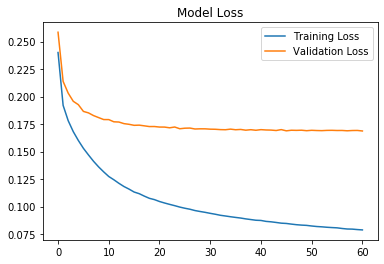

Saved model to disk
Train data : sketch image


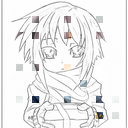

Train data : color image


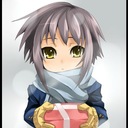

Train data : Generated image


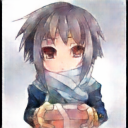

Train data : sketch image


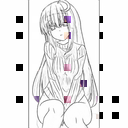

Train data : color image


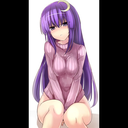

Train data : Generated image


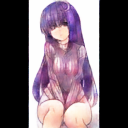

Validation data : sketch image


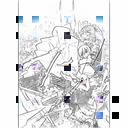

Validation data : color image


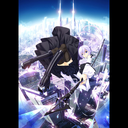

Validation data : Generated image


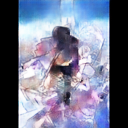

Validation data : sketch image


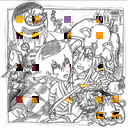

Validation data : color image


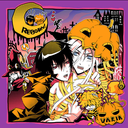

Validation data : Generated image


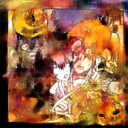

Iteration number: 79
Elapsed Time: 7:12:48.762927
Training Loss: [0.24003536, 0.19203436, 0.17810456, 0.16813812, 0.16012341, 0.15298101, 0.14695488, 0.141184, 0.13609621, 0.13156357, 0.1273665, 0.124409445, 0.121176064, 0.118250735, 0.115897134, 0.113256395, 0.11176272, 0.1095536, 0.10755104, 0.10636716, 0.1046526, 0.10328875, 0.102036916, 0.10086191, 0.09958117, 0.09852598, 0.097624734, 0.09641768, 0.095572405, 0.09479816, 0.09389701, 0.09307278, 0.092126735, 0.091483675, 0.09080186, 0.09018842, 0.08961847, 0.088857755, 0.088244, 0.08762115, 0.08742854, 0.08658026, 0.086185664, 0.08560257, 0.08496575, 0.08470075, 0.084103286, 0.08357076, 0.08319856, 0.082952015, 0.08238812, 0.081923984, 0.081633605, 0.08124385, 0.08096059, 0.08071973, 0.080127686, 0.07966286, 0.07955145, 0.07914931, 0.07882937, 0.07852107, 0.078166954, 0.07792271, 0.07754734, 0.077409804, 0.07705437, 0.07690265, 0.07658732, 0.07624102, 0.076097146, 0.0756892, 0.07553472, 0.075283505, 0.07517786, 0.07479652, 0.0745870

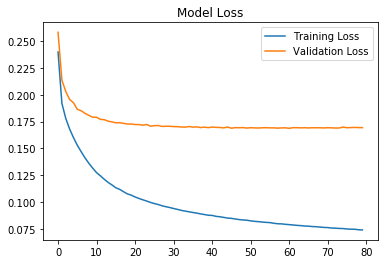

Saved model to disk
Train data : sketch image


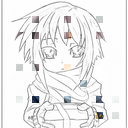

Train data : color image


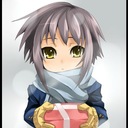

Train data : Generated image


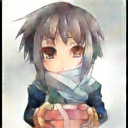

Train data : sketch image


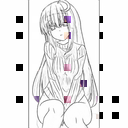

Train data : color image


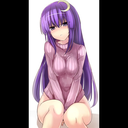

Train data : Generated image


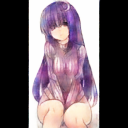

Validation data : sketch image


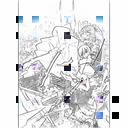

Validation data : color image


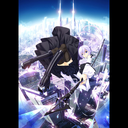

Validation data : Generated image


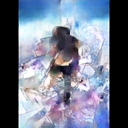

Validation data : sketch image


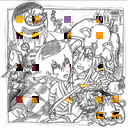

Validation data : color image


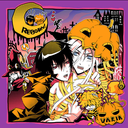

Validation data : Generated image


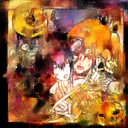

In [19]:
#Train the model to generate images.

epochs = 80    #Number of epochs.
batch_size = 4 #Batch Size.

#Length of train dataset.
len_tr = len(img_tr) 

#List to store results.
tr_loss_hist, val_loss_hist = list(), list()
tr_loss_hist_epoch, val_loss_hist_epoch = list(), list()
tr_loss_hist_itr, val_loss_hist_itr = list(), list()

#Calling initial model to generate images
model = color_image()

#Timer
start_time = datetime.now()

#Training for number of epochs.
for e in range(epochs):

  #Looping for number of iterations so that all images gets processed atleast once in epoch.
  for i in range(int(len_tr/batch_size)):
  
    #Generate batch of train data.
    xs, ys = generate_train_batch(img_tr, batch_size)
   
    #Train model on batch of data generated above.   
    tr_loss = model.train_on_batch(xs,ys)

    #Generate batch of validation data.
    xs, ys = generate_val_batch(img_val, batch_size)

    #Test model on validation data
    val_loss = model.test_on_batch(xs,ys)    

    #Append performances.
    tr_loss_hist_itr.append(tr_loss)
    val_loss_hist_itr.append(val_loss)
  
  #Updating values at epoch level in order to generate plots.
  tr_loss_hist_epoch.append(np.mean(np.array(tr_loss_hist_itr)))
  val_loss_hist_epoch.append(np.mean(np.array(val_loss_hist_itr)))
  
  tr_loss_hist_itr, val_loss_hist_itr = list(), list()

  #Print results after every 20 epoch.
  if e == 1 or e % 20 == 0 or e% (epochs-1) == 0:
     print('Iteration number:',e)   
     elapsed_time = datetime.now() - start_time
     print('Elapsed Time:', elapsed_time)
     print('Training Loss:',tr_loss_hist_epoch)
     print('Validation Loss:',val_loss_hist_epoch) 
     if  (e % 20 == 0 or e% (epochs-1) == 0) and (e != 0):
         plot_history(tr_loss_hist_epoch, val_loss_hist_epoch) 
         #Saving the model.
         model.save_weights('model1_' + str(e) + '.h5')
         print("Saved model to disk")
     #Generating images using model trained.    
     summarize_performance(model)

In [0]:
#Show generated images.

n_samples = 10 #Number of sample want to be printed.


#Resetting pointers to zero.
train_batch_pointer = 0
val_batch_pointer = 0

#Generate batch of skecth and corresponding color images.
X_tr, Y_tr = generate_train_batch(img_tr, n_samples)

#Generate batch of skecth and corresponding color images.
X_val, Y_val = generate_val_batch(img_val, n_samples)

val_batch_pointer = 0

#Generate batch of skecth and corresponding color images.
X_ts, Y_ts = generate_val_batch(img_tst, n_samples)


#Resetting pointers to zero.
train_batch_pointer = 0
val_batch_pointer = 0


#Function to generate 10 generated image from each train, validation and test data.
def print_results(model):
  
  #Generate image on 10 samples from train data.
  gen_arr = model.predict(X_tr)

  for i in range(10):
    print('Train data : sketch image')
    #Convertng the generated image back to 0-255 value format.
    img = ((X_tr[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)

    print('Train data : color image')
    #Convertng the generated image back to 0-255 value format.
    img = ((Y_tr[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)

    print('Train data : Generated image')
    #Convertng the generated image back to 0-255 value format.
    img = ((gen_arr[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)
  
  #Generate image on 10 samples from validation data.
  gen_arr = model.predict(X_val)

  for i in range(10):
    print('Validation data : sketch image')
    #Convertng the generated image back to 0-255 value format.
    img = ((X_val[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)

    print('Validation data : color image')
    #Convertng the generated image back to 0-255 value format.
    img = ((Y_val[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)

    print('Validation data : Generated image')
    #Convertng the generated image back to 0-255 value format.
    img = ((gen_arr[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)

  #Generate image on 10 samples from test data.
  gen_arr = model.predict(X_ts)
  
  for i in range(10):
    print('Test data : sketch image')
    #Convertng the generated image back to 0-255 value format.
    img = ((X_ts[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)

    print('Test data : color image')
    #Convertng the generated image back to 0-255 value format.
    img = ((Y_ts[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)

    print('Test data : Generated image')
    #Convertng the generated image back to 0-255 value format.
    img = ((gen_arr[i]+ 1)/2.0)*255.0
    #Converting back to BGR format required by cv2 library.
    img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
    #Show image.
    cv2_imshow(img)

Train data : sketch image


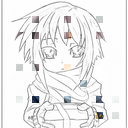

Train data : color image


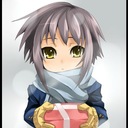

Train data : Generated image


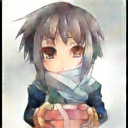

Train data : sketch image


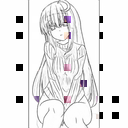

Train data : color image


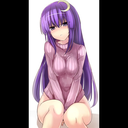

Train data : Generated image


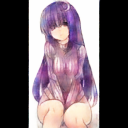

Train data : sketch image


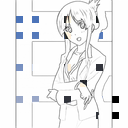

Train data : color image


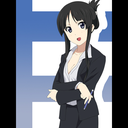

Train data : Generated image


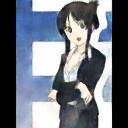

Train data : sketch image


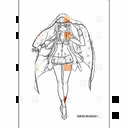

Train data : color image


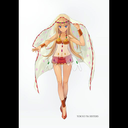

Train data : Generated image


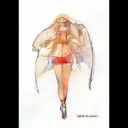

Train data : sketch image


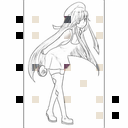

Train data : color image


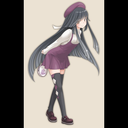

Train data : Generated image


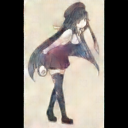

Train data : sketch image


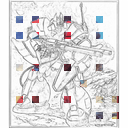

Train data : color image


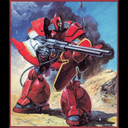

Train data : Generated image


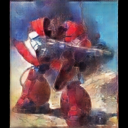

Train data : sketch image


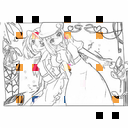

Train data : color image


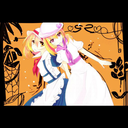

Train data : Generated image


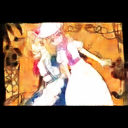

Train data : sketch image


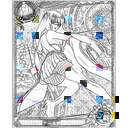

Train data : color image


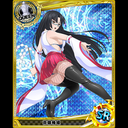

Train data : Generated image


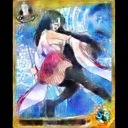

Train data : sketch image


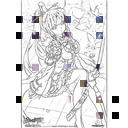

Train data : color image


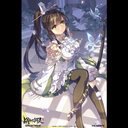

Train data : Generated image


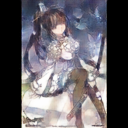

Train data : sketch image


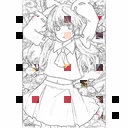

Train data : color image


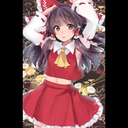

Train data : Generated image


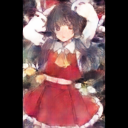

Validation data : sketch image


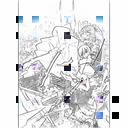

Validation data : color image


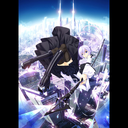

Validation data : Generated image


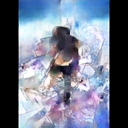

Validation data : sketch image


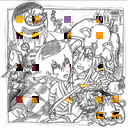

Validation data : color image


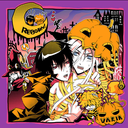

Validation data : Generated image


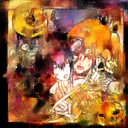

Validation data : sketch image


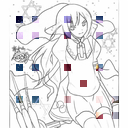

Validation data : color image


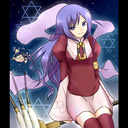

Validation data : Generated image


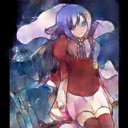

Validation data : sketch image


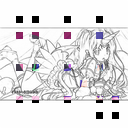

Validation data : color image


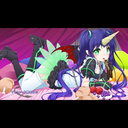

Validation data : Generated image


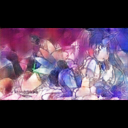

Validation data : sketch image


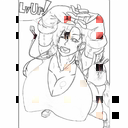

Validation data : color image


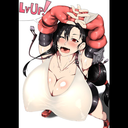

Validation data : Generated image


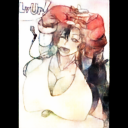

Validation data : sketch image


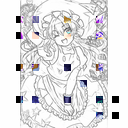

Validation data : color image


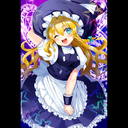

Validation data : Generated image


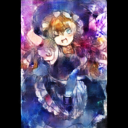

Validation data : sketch image


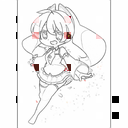

Validation data : color image


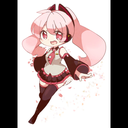

Validation data : Generated image


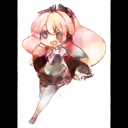

Validation data : sketch image


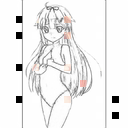

Validation data : color image


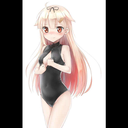

Validation data : Generated image


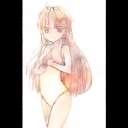

Validation data : sketch image


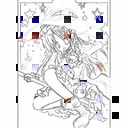

Validation data : color image


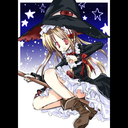

Validation data : Generated image


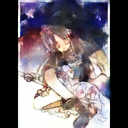

Validation data : sketch image


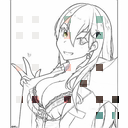

Validation data : color image


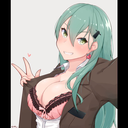

Validation data : Generated image


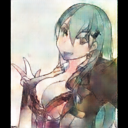

Test data : sketch image


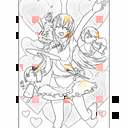

Test data : color image


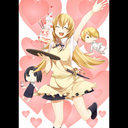

Test data : Generated image


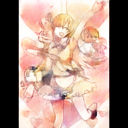

Test data : sketch image


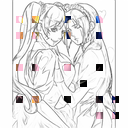

Test data : color image


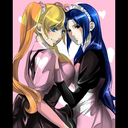

Test data : Generated image


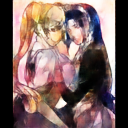

Test data : sketch image


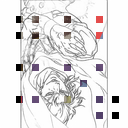

Test data : color image


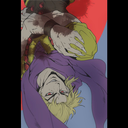

Test data : Generated image


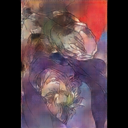

Test data : sketch image


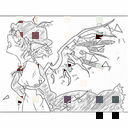

Test data : color image


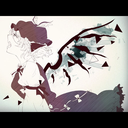

Test data : Generated image


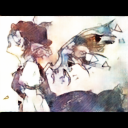

Test data : sketch image


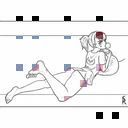

Test data : color image


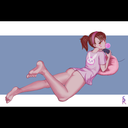

Test data : Generated image


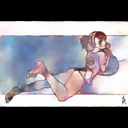

Test data : sketch image


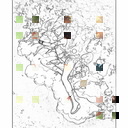

Test data : color image


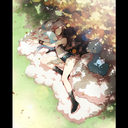

Test data : Generated image


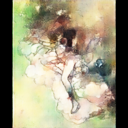

Test data : sketch image


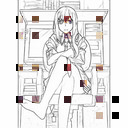

Test data : color image


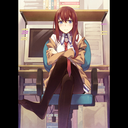

Test data : Generated image


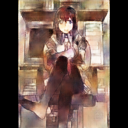

Test data : sketch image


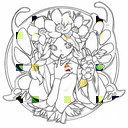

Test data : color image


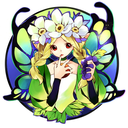

Test data : Generated image


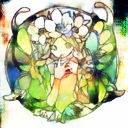

Test data : sketch image


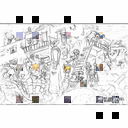

Test data : color image


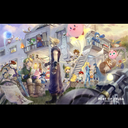

Test data : Generated image


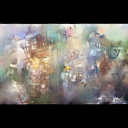

Test data : sketch image


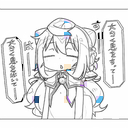

Test data : color image


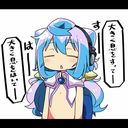

Test data : Generated image


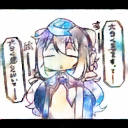

In [21]:
#Generate images on some train, validation and test images using model trained above.
print_results(model)

**5. Model Comparision**

In [1]:
#Models with better results.
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model Name", "Number of Epochs", "Epochs with best results", "Train Loss", "Test Loss"]
x.add_row(["Unet for Sketch Image", 250, 250, 0.070, 0.306])
x.add_row(["Unet for Sketch Image with Color Hint", 80, 40, 0.073, 0.169])
print(x)

+---------------------------------------+------------------+--------------------------+------------+-----------+
|               Model Name              | Number of Epochs | Epochs with best results | Train Loss | Test Loss |
+---------------------------------------+------------------+--------------------------+------------+-----------+
|         Unet for Sketch Image         |       250        |           250            |    0.07    |   0.306   |
| Unet for Sketch Image with Color Hint |        80        |            40            |   0.073    |   0.169   |
+---------------------------------------+------------------+--------------------------+------------+-----------+


**7. Steps Followed**

- Downloaded data from Danbooru Sketch Pair 128x on kaggle https://www.kaggle.com/wuhecong/danbooru-sketch-pair-128xsv"
- Unzipped the folder.
- Imported all the required libraries. We have uses - Keras libraries, numpy, os, random, cv2, matplotlib.pyplot
- Loaded test data and generated image using model on train and test data.
- Also, generated Scalar graphs using Tensorboard. 
- Then defined an U-net model. Defined below functions -
    - U-net model
    - Generate Sample for batch processing
    - Plot history
    - Summarize performance.
    - Training
    - Write Log
- Trained the model and plotted results.
- Saved model weights.
- Generated images on train and test data using model generated above.
- Also, generated Scalar graphs using Tensorboard. 




**8. References**


*   https://machinelearningmastery.com/a-gentle-introduction-to-pix2pix-generative-adversarial-network/

*   https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/

*   https://arxiv.org/pdf/1611.07004v1.pdf
*   https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/


*   https://www.kaggle.com/wuhecong/danbooru-sketch-pair-128x
*   https://github.com/kvfrans/deepcolor/blob/master/main.py
- https://towardsdatascience.com/sketch-to-color-anime-translation-using-generative-adversarial-networks-gans-8f4f69594aeb
- https://arxiv.org/pdf/1808.03240.pdf
- http://kvfrans.com/coloring-and-shading-line-art-automatically-through-conditional-gans/
- https://arxiv.org/pdf/1705.01908v2.pdf





